# Running MAGIC and PHATE on Immunometabolism dataset
**Author:** Scott Campit

# Summary
This notebook performs data imputation using MAGIC for single-cell COBRA analyses.

To visualize the results, we will use PHATE, which was also developed in the same lab.

In [1]:
#!pip install --user magic-impute
#!pip install --user phate
import magic
import phate
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

c:\users\scott\envs\python\immune\scripts\python.exe
3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:23:07) [MSC v.1927 32 bit (Intel)]
sys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)


# 1. Import data
First, let's import the immunometabolism data. I saved the data as three separate files:
  1. lung.csv: the count matrix
  2. active_ident.csv: the cell type annotation
  3. symbol: the gene symbol identifiers.

In [2]:
# Read in count matrix
datapath = r"C:\Users\scott\Data\scRNASeq\shea\lung.csv"
tmp = list()
for chunk in pd.read_csv(datapath, sep=',', header=None, skiprows=1, engine='c', chunksize=1000, dtype=np.int16, low_memory=False):
    tmp.append(chunk)
counts = pd.concat(tmp, axis=0)

The data is current arranged where the rows are genes and the columns are cell lines. Let's transpose the matrix so that columns are genes and rows are cell lines.

In [5]:
counts = counts.transpose()
print(counts.shape)
print(counts.head())

(16431, 7297)
   0     1     2     3     4     5     6     7     8     9     ...  7287  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     1  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   7288  7289  7290  7291  7292  7293  7294  7295  7296  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     1     0     0     1     0     0     2  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 7297 columns]


# 2. Data Preprocessing
Let's now perform some data filtering.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

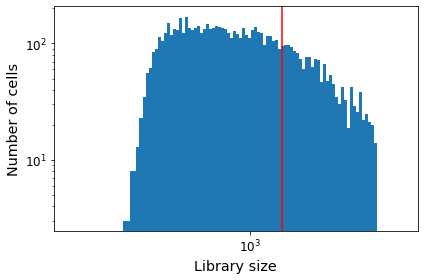

In [4]:
scprep.plot.plot_library_size(counts, cutoff=1500)

In [5]:
# be sure to uncomment this, unless your data is pre-filtered
#counts = scprep.filter.filter_library_size(counts, cutoff=1500)
#counts.head()

,0,1,2,3,4,5,6,7,8,9,...,16421,16422,16423,16424,16425,16426,16427,16428,16429,16430
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's normalize the data.

In [6]:
#counts = scprep.normalize.batch_mean_center(counts)
#counts.head()

,0,1,2,3,4,5,6,7,8,9,...,16421,16422,16423,16424,16425,16426,16427,16428,16429,16430
9,-0.040915,-0.025872,-0.187124,0.929603,-0.01083,-0.011432,-0.035499,-0.000602,-0.025872,-0.146209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,-0.040915,-0.025872,-0.187124,-0.070397,-0.01083,-0.011432,-0.035499,-0.000602,-0.025872,-0.146209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,-0.040915,-0.025872,0.812876,-0.070397,-0.01083,-0.011432,-0.035499,-0.000602,-0.025872,-0.146209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,-0.040915,-0.025872,-0.187124,-0.070397,-0.01083,-0.011432,-0.035499,-0.000602,-0.025872,-0.146209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,-0.040915,-0.025872,-0.187124,-0.070397,-0.01083,-0.011432,-0.035499,-0.000602,-0.025872,-0.146209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
magic_op = magic.MAGIC()
lung_mag = magic_op.fit_transform(counts, genes="all_genes")

Calculating MAGIC...
  Running MAGIC on 7297 cells and 16431 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
  Calculated graph and diffusion operator in 0.04 seconds.
Calculated MAGIC in 0.21 seconds.


c:\users\scott\envs\python\immune\lib\site-packages\magic\magic.py:474: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


MemoryError: Unable to allocate 915. MiB for an array with shape (7297, 16431) and data type float64

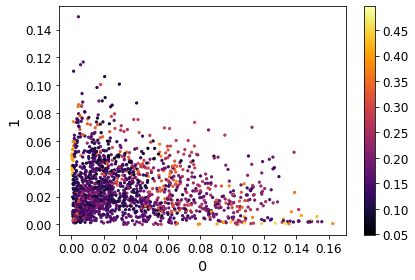

In [8]:
scprep.plot.scatter(x=lung_mag[0],
                    y=lung_mag[1], 
                    c=lung_mag[2])

plt.tight_layout()
plt.show()

In [9]:
print(lung_mag.shape)

(1662, 16431)
